The main Figure 1 and 2, Supplementary Figure S1 and S2 can be reproduced using the code below.

For *Escherichia coli*, we first analyzed the GFP expression dataset from Cambray *et al.* (2018).
The Supplementary Data 15 is very large and not easy to download (125 MB). ```cambray.cdhit.fa``` and ```cambray.cdhit.txt``` in this repo can be used instead.

```console
mkdir -p data
cd data
wget https://media.nature.com/original/nature-assets/nbt/journal/v36/n10/extref/nbt.4238-S47.zip
md5sum nbt.4238-S47.csv.zip
```

```console
177afbcae1732c7c4bd5f444f6c99d10  nbt.4238-S47.csv.zip
```

This csv file contains four columns of our interest- ```id```, ```gs.utrCdsStructureMFE```, ```clean.lin.prot.mean```, and ```gs.sequence```, which correspond to the sequence ID, minimum free energy -30:30, GFP level, and 96 nt upstream sequences, respectively. Representative sequences of these 96 nt upstream sequences were selected using ```cd-hit-est```.

```console
unzip nbt.4238-S47.zip
awk 'BEGIN{FS=","} NR>1 {gsub("\"", ""); print ">" $1, $15, $33 "\n" toupper($5)}' \
Supplementary_Data_15_Integrated_Phenotypic_Measurements.csv > cambray.fa
cd-hit-est -i cambray.fa -o cambray.cdhit.fa -c 0.8 -p 1
awk 'BEGIN{OFS="\t"} />/ {sub(">",""); gsub(" ","\t"); print $1,$2,$3}' cambray.cdhit.fa \
| sed '1i id\tMinimum free energy\tProtein abundance' > cambray.cdhit.txt
```

Accessibility of the GFP sequences was calculated using an ```RNAplfold``` wrapper script ```openen.py```.

```console
# Addgene 113408
UTR5=AAAAAGAGTATTGACTTATTGTGAGCGGATAACATATAATGTGTGGAGGGCCCAAGTTCACTTAAAAAGGAGATCAACAATGAAAGCAATTTAGGTACTGAAACATCTTAATCATGCACATAAGGAGGTACCATA
GFP=GGTGGATCCGGTGGATCGGGCGGGTCATACTACCATCACCACCACCACCATTTGGAGTCGGAAAATTTATACTTCCAATCCGGTTCCGCCGGATCTGCTGCCGGTTCCGGTGAATTTAGCAAAGGAGAAGAACTTTTCACCGGAGTAGTCCCGATTCTGGTTGAATTAGATGGTGATGTTAATGGGCACAAATTTTCTGTCCGTGGAGAGGGTGAAGGTGATGCTACAAACGGAAAACTCACCCTTAAATTCATTTGCACAACGGGAAAACTACCAGTACCGTGGCCAACACTGGTCACTACTCTGACCTATGGTGTTCAATGCTTTTCCCGTTATCCGGATCACATGAAACGGCATGACTTTTTCAAGAGTGCCATGCCCGAAGGTTATGTACAGGAACGCACTATATCTTTCAAAGATGACGGGACCTACAAGACGCGTGCTGAAGTCAAGTTTGAAGGTGATACCCTTGTTAATCGTATCGAGTTAAAGGGTATTGATTTTAAAGAAGATGGAAACATTCTTGGACACAAACTCGAGTACAACTTTAACTCACACAATGTATACATCACGGCAGACAAACAAAAGAATGGAATCAAAGCTAACTTCAAAATTCGCCACAACGTTGAAGATGGTTCCGTTCAACTAGCTGAGCATTATCAACAAAATACTCCAATTGGAGATGGACCTGTCCTTTTACCAGACAACCATTACCTGTCGACACAATCTGTCCTTTCGAAAGATCCCAACGAAAAGCGTGACCACATGGTCCTTCTTGAGTTTGTAACTGCTGCTGGGATTACACATGGCATGGATGAGCTCTACAAATAAGGATCGGTTGTCGAGTAAGGATCTCCAGGCATCAAATAAAACGAAAGGCTCAGTCGAAAGACTGGGCCTTTCGTTTTATCTGTTGTTTGTCGGTGAACGCTCTCTACTAGAGTCACACTGGCTCACCTTCGGGTGGGCCTTTCTGCGTTTATA

# Concatenate 5'UTR, 33 N-terminal codons and GFP sequences 
awk 'BEGIN{RS=">"}NR>1{sub("\n","\t"); gsub("\n",""); print RS$0}' cambray.cdhit.fa \
| awk -v i=$UTR5 -v j=$GFP '{print $1 "\n" i "ATG" $NF j}' > cambray.cdhit.gfp.fa

# 5'UTR length is 135
python ../openen.py -s cambray.cdhit.gfp.fa -U 1 -x -e -n 135 -S -o openen.cambray
cd ..
```

```.pkl``` and ```.out``` output files were used for correlation analysis as follows.

In [1]:
import os
import csv
from datetime import datetime
from functools import reduce
import numpy as np
from numpy import nan as Nan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve

# Calculate correlation of protein abundance and opening energy
# at individual transcript sub-sequences
def correlation(j, d):
    for i in list(range(0,j)):
        yield d[pd.np.r_[i, j]].corr(method='spearman')[i][j]

# Calculate AUC and average precision score of recombinant protein expression results and opening energy
# at individual transcript sub-sequences
def performance(outcomes, d):
    for predictions in list(range(0,outcomes)):
        df = d[pd.np.r_[predictions, outcomes]]
        auroc = roc_auc_score(df[outcomes], -df[predictions])
        ap = average_precision_score(df[outcomes], -df[predictions])
        yield predictions, auroc, ap

# Flatten _openen files
# n is 5UTR length
# t is downstream distance to start codon to include
def openen_label(n, t, f):
    d = pd.read_csv(f, sep='\t', skiprows=2, nrows=(n+t), header=None)
    d = d.set_index(0).stack().to_frame()
    d = d.index.to_frame()
    d.columns = ["Position 'i' centered at the start codon", "Sub-sequence 'l'"]
    d = d.reset_index()[["Position 'i' centered at the start codon", "Sub-sequence 'l'"]]
    d["Position 'i' centered at the start codon"] = d["Position 'i' centered at the start codon"] - n
    return d

# Get opening energy at a specific sub-sequence 'l'
# and position 'i' centered at the start codon
def get_openen(n, t, f1, l, i, f2):
    label = openen_label(n, t, f1)
    d = pd.read_pickle(f2)
    d = d.set_index('id')
    d = d.T
    d = pd.concat([label, d], axis=1)
    o = d.loc[(d["Sub-sequence 'l'"] == l) & (d["Position 'i' centered at the start codon"] == i)]
    o = o.T[2:]
    o.columns = ['Opening energy']
    return o

# Fig 1 and 2
def plot_joinplot(x, y, d, c, savepdf=None):
    %matplotlib inline
    if savepdf:
        %config InlineBackend.figure_format = 'pdf'
        sns.set(font_scale=1.6)
        sns.set_style('ticks')
        sns.jointplot(x, y, data=d, color=c, kind='kde', space=0)
        fname = 'joinpoint_' + str(datetime.now()).replace(" ","_") + '.pdf'
        fpath = os.path.join(os.getcwd(), 'data', fname)
        plt.savefig(fpath)
    else:
        %config InlineBackend.figure_format = 'retina'
        sns.set(font_scale=1.6)
        sns.set_style('ticks')
        sns.jointplot(x, y, data=d, color=c, kind='kde', space=0)
        
# Fig 2 and Supplementary Fig S1
# span is the tick interval of x- or y- axis
def plot_heatmap(xspan, yspan, d, colorflip=None, savepdf=None):
    %matplotlib inline
    if colorflip:
        cmap = sns.cm.rocket_r
    else:
        cmap = sns.cm.rocket
    if savepdf:   
        %config InlineBackend.figure_format = 'pdf'
        plt.rcParams['figure.figsize'] = [9, 4.5]     
        sns.set(font_scale=1.5)
        sns.set_style('ticks')
        sns.heatmap(d, cmap = cmap, xticklabels=xspan, yticklabels=yspan)
        fname = 'heatmap_' + str(datetime.now()).replace(" ","_") + '.pdf'
        fpath = os.path.join(os.getcwd(), 'data', fname)
        plt.savefig(fpath)
    else:
        %config InlineBackend.figure_format = 'retina'
        plt.rcParams['figure.figsize'] = [9, 4.5]
        sns.set(font_scale=1.5)
        sns.set_style('ticks')
        sns.heatmap(d, cmap = cmap, xticklabels=xspan, yticklabels=yspan)

In [2]:
# Read in pickle file for correlation analysis
d = pd.read_pickle('data/openen.cambray.pkl')
d.head()

,id,0,1,2,3,4,5,6,7,8,...,27395,27396,27397,27398,27399,27400,27401,27402,27403,27404
0,1_11111113_1,0.0027,0.0061,0.0077,0.0529,0.0573,0.0589,0.0720,0.0927,0.0964,...,57.3627,57.2981,57.2577,57.1814,57.1046,57.0203,56.9116,56.7795,56.5800,56.8805
1,1_11111112_1,0.0024,0.0050,0.0064,0.0511,0.0517,0.0520,0.0553,0.0738,0.0728,...,53.5835,53.5194,53.4718,53.4098,53.3380,53.2667,53.1730,53.0874,52.9976,52.8122
2,1_11112111_1,0.0006,0.0013,0.0017,0.0055,0.0065,0.0074,0.0089,0.0112,0.0119,...,53.5211,53.4575,53.4080,53.3446,53.2620,53.1955,53.1184,53.0624,53.0247,52.9689
3,1_11112113_1,0.0008,0.0024,0.0031,0.0058,0.0081,0.0089,0.0130,0.0158,0.0181,...,48.7943,48.7300,48.6836,48.6203,48.5583,48.4840,48.3841,48.2854,48.1654,47.9369
4,1_11111121_1,0.0036,0.0072,0.0093,0.0695,0.0735,0.0753,0.0753,0.1019,0.1049,...,50.4474,50.3861,50.3336,50.2746,50.1925,50.1399,50.0953,50.1010,50.2264,50.4838


In [3]:
d.shape

(14425, 27406)

In [4]:
f = pd.read_csv('data/cambray.cdhit.txt', sep='\t')
f.head()

,id,Minimum free energy,Protein abundance
0,1_11111111_1,-12.6,27.510097
1,1_11111112_1,-11.6,36.376262
2,1_11111113_1,-14.1,16.825186
3,1_11111121_1,-13.2,11.591014
4,1_11111123_1,-14.8,6.801931


In [5]:
# Assign the column name 'Protein abundance' to 27405, i.e., the last column number
# and join the dataframes for calculating correlation
f = f[['id','Protein abundance']]
f.columns = ['id', 27405]
d = pd.merge(d, f, on='id')

In [6]:
# Calculate correlation at individual sub-sequence 'l' (length 1 to 'u')
corr = pd.DataFrame(correlation(27405, d))
corr.columns = ['corr']
# Get labels (row and column names) from an _openen file
# Join labels and correlation values
label = openen_label(135, 100, 'data/321_23311221_1_openen')
d = pd.concat([label, corr], axis=1)
d.to_pickle('data/corr.cambray.pkl')

In [7]:
# Opening energy at i=18 and l=48 (transcript region -30 to 18 nt)
# has the strongest correlation with protein level
d = pd.read_pickle('data/corr.cambray.pkl')
d.sort_values('corr').head()

,Position 'i' centered at the start codon,Sub-sequence 'l',corr
11675,18,48,-0.646008
11674,18,47,-0.645767
11676,18,49,-0.645478
11677,18,50,-0.644265
11678,18,51,-0.643979


In [8]:
# Add padding to x-axis
d_dummy = pd.DataFrame([-135,1,Nan], index=["Position 'i' centered at the start codon", "Sub-sequence 'l'", 'corr']).T
d = d_dummy.append(d)
d["Position 'i' centered at the start codon"] = d["Position 'i' centered at the start codon"].astype('int')
d["Sub-sequence 'l'"] = d["Sub-sequence 'l'"].astype('int')

In [9]:
# Transform correlation values to a dataframe similar to that of _openen
d = d.pivot(index="Position 'i' centered at the start codon", columns="Sub-sequence 'l'", values='corr').T.sort_values("Sub-sequence 'l'", ascending=False)

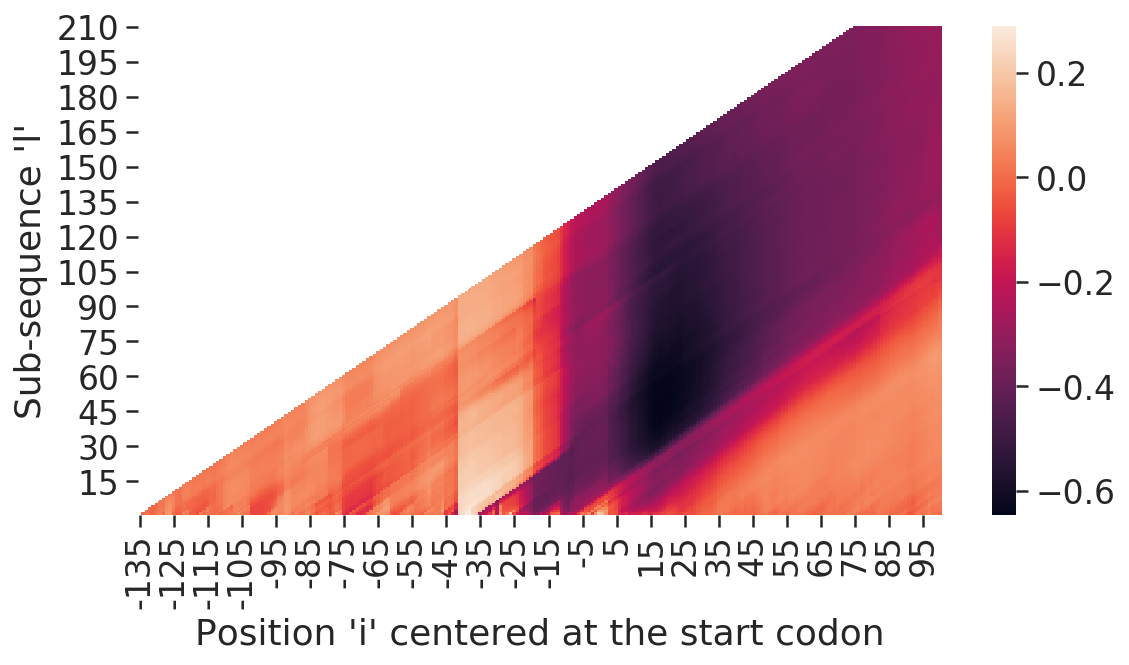

In [10]:
# Fig 2B and Supplementary Fig 1A, left panel
plot_heatmap(10, 15, d)

In [11]:
# Get opening energy at transcript region -30 to 18 nt
o = get_openen(135, 100, 'data/321_23311221_1_openen', 48, 18, 'data/openen.cambray.pkl')

In [12]:
# Calculate pairwise correlation
f = pd.read_csv('data/cambray.cdhit.txt', sep='\t')
f = f.set_index('id')
d = pd.concat([o, f], sort=True, axis=1)
d.corr(method='spearman')

,Opening energy,Minimum free energy,Protein abundance
Opening energy,1.000000,-0.577458,-0.646008
Minimum free energy,-0.577458,1.000000,0.509407
Protein abundance,-0.646008,0.509407,1.000000


In [13]:
# d[d.isnull().any(1)]
spearmanr(d['Opening energy'], d['Protein abundance'], nan_policy='omit')

SpearmanrResult(correlation=-0.6460079512251886, pvalue=0.0)

In [14]:
# spearmanr can print P-value smaller than 2.2e-16, 
# which is the smaller than the machine precision level used by R
# Bonferroni correction for P=2.2e-16 when the number of test is 14425*27406
(2.2e-16)*14425*27406

8.6972941e-08

In [15]:
spearmanr(d['Minimum free energy'], d['Protein abundance'], nan_policy='omit')

SpearmanrResult(correlation=0.5094070220472339, pvalue=0.0)

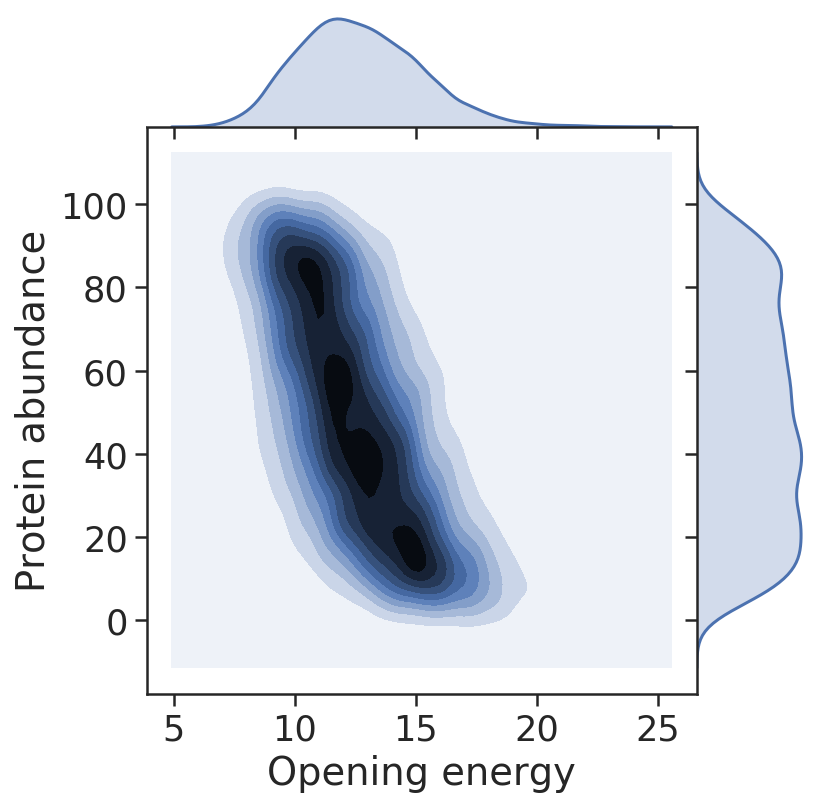

In [16]:
# Fig 1A, left panel
plot_joinplot('Opening energy', 'Protein abundance', d, 'b')

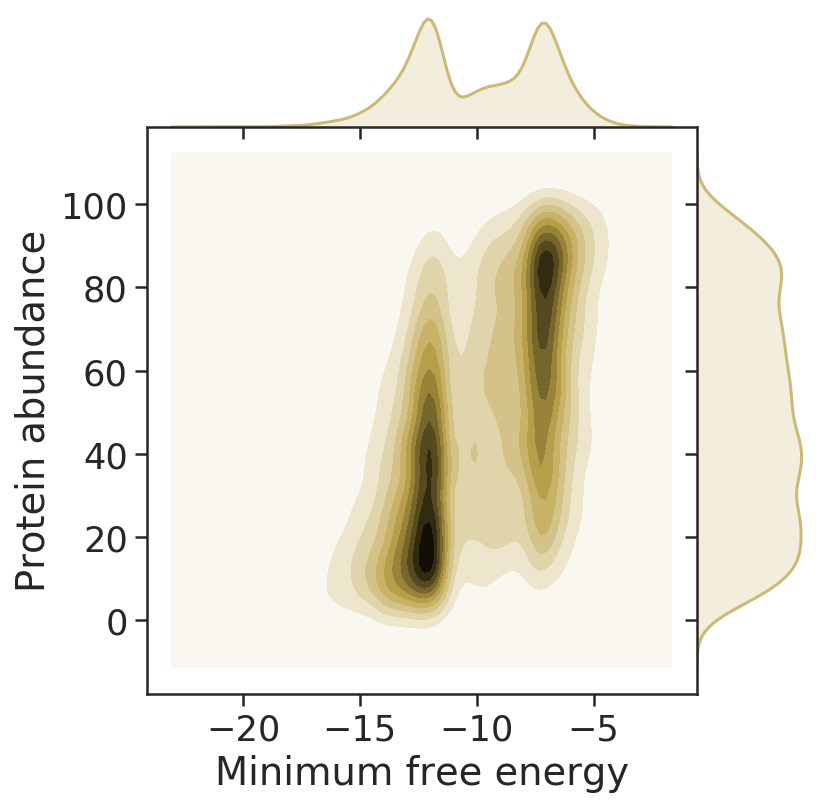

In [17]:
# Fig 1A, left panel
plot_joinplot('Minimum free energy', 'Protein abundance', d, 'y')

For *Saccharomyces cerevisiae*, we analyzed the YFP expression dataset from Dvir et al. (2013).

```console
# Table S4 and Method S2, https://www.pnas.org/highwire/filestream/613140/field_highwire_adjunct_files/0/sapp.pdf
UTR5=AAAACAA
YFP=ATGTCTAAAGGTGAAGAATTATTCACTGGTGTTGTCCCAATTTTGGTTGAATTAGATGGTGATGTTAATGGTCACAAATTTTCTGTCTCCGGTGAAGGTGAAGGTGATGCTACTTACGGTAAATTGACCTTAAAATTGATTTGTACTACTGGTAAATTGCCAGTTCCATGGCCAACCTTAGTCACTACTTTAGGTTATGGTTTGCAATGTTTTGCTAGATACCCAGATCATATGAAACAACATGACTTTTTCAAGTCTGCCATGCCAGAAGGTTATGTTCAAGAAAGAACTATTTTTTTCAAAGATGACGGTAACTACAAGACCAGAGCTGAAGTCAAGTTTGAAGGTGATACCTTAGTTAATAGAATCGAATTAAAAGGTATTGATTTTAAAGAAGATGGTAACATTTTAGGTCACAAATTGGAATACAACTATAACTCTCACAATGTTTACATCACTGCTGACAAACAAAAGAATGGTATCAAAGCTAACTTCAAAATTAGACACAACATTGAAGATGGTGGTGTTCAATTAGCTGACCATTATCAACAAAATACTCCAATTGGTGATGGTCCAGTCTTGTTACCAGACAACCATTACTTATCCTATCAATCTGCCTTATCCAAAGATCCAAACGAAAAGAGAGACCACATGGTCTTGTTAGAATTTGTTACTGCTGCTGGTATTACCCATGGTATTGATGAATTGTACAAATAA

# Download the supplementary data and calculate opening energy
wget https://www.pnas.org/highwire/filestream/613140/field_highwire_adjunct_files/1/sd01.xlsx
libreoffice --headless --convert-to csv sd01.xlsx
awk -v u=$UTR5 -v s=$YFP 'BEGIN{FS=","} NR>1 {print ">" $1 "\n" u $1 s}' sd01.csv > dvir13.fa
python ../openen.py -s dvir13.fa -x -U 1 -S -n 17 -t 300 -p 32 -o openen.dvir

# Calculate the minimum free energy -30:30
awk 'BEGIN{FS=","} NR>1 {print ">" $1 "\nAACAA" $1 "ATGTCTAAAGGTGAAGAATTATTCACTGGTGTTGTCCCAATTTTGGTTGA"}' sd01.csv \
| RNAfold --noPS \
| awk 'BEGIN{RS=">"}NR>1{sub("\n","\t"); gsub("\n",""); print $0}' \
| awk '{gsub(/\(|\)/," "); print $1 "\t" $NF}' \
| sed '1i id\tMinimum free energy' > rnafold.dvir.out
cd ..
```

In [18]:
d = pd.read_pickle('data/openen.dvir.pkl')
d.head()

,id,0,1,2,3,4,5,6,7,8,...,44615,44616,44617,44618,44619,44620,44621,44622,44623,44624
0,CCGACCCGTT,0.0062,0.0080,0.0114,0.0080,0.0143,0.0173,0.0149,0.0185,0.0245,...,51.0103,51.0531,51.1029,51.1678,51.2562,51.3802,51.4491,51.5449,51.5928,51.7325
0,AATCTACGTT,0.0016,0.0027,0.0045,0.0400,0.0456,0.0432,0.1333,0.1755,0.2136,...,51.0103,51.0531,51.1029,51.1678,51.2562,51.3802,51.4491,51.5449,51.5928,51.7325
0,ATCGGAAGTT,0.0005,0.0012,0.0017,0.0040,0.0059,0.0059,0.0149,0.0189,0.0232,...,51.0103,51.0531,51.1029,51.1678,51.2562,51.3802,51.4491,51.5449,51.5928,51.7325
0,TTCCAGCCTT,0.0014,0.0022,0.0031,0.0044,0.0054,0.0062,0.6902,0.6915,0.7010,...,51.0103,51.0531,51.1029,51.1678,51.2562,51.3802,51.4491,51.5449,51.5928,51.7325
0,CTTACACCTT,0.0031,0.0061,0.0080,0.0091,0.0122,0.0142,0.0488,0.0545,0.0538,...,51.0103,51.0531,51.1029,51.1678,51.2562,51.3802,51.4491,51.5449,51.5928,51.7325


In [19]:
d.shape

(2041, 44626)

In [20]:
f = pd.read_csv('data/sd01.csv')
f = f[['sequence_variant','mean_protein_abundance']]
f.columns = ['id', 44625]
d = pd.merge(d, f, on='id')

In [21]:
corr = pd.DataFrame(correlation(44625, d))
corr.columns = ['corr']
label = openen_label(17, 300, 'data/AAAAAAAATC_openen')
d = pd.concat([label, corr], axis=1)
d.to_pickle('data/corr.dvir.pkl')

In [22]:
d = pd.read_pickle('data/corr.dvir.pkl')
d.sort_values('corr').head()

,Position 'i' centered at the start codon,Sub-sequence 'l',corr
5660,89,96,-0.551764
5767,90,97,-0.551356
5554,88,95,-0.551169
5346,86,94,-0.551133
5449,87,94,-0.551070


In [23]:
# Position i=-20 is a padding at x-axis
# Add padding to x-axis
d_dummy = pd.DataFrame({"Position 'i' centered at the start codon":[-17,-18,-19,-20], "Sub-sequence 'l'":[1,1,1,1], 'corr':[Nan,Nan,Nan,Nan]})
d = d_dummy.append(d)
d = d[d["Position 'i' centered at the start codon"]<=210]
d = d.pivot(index="Position 'i' centered at the start codon", columns="Sub-sequence 'l'", values='corr').T.sort_values("Sub-sequence 'l'", ascending=False)

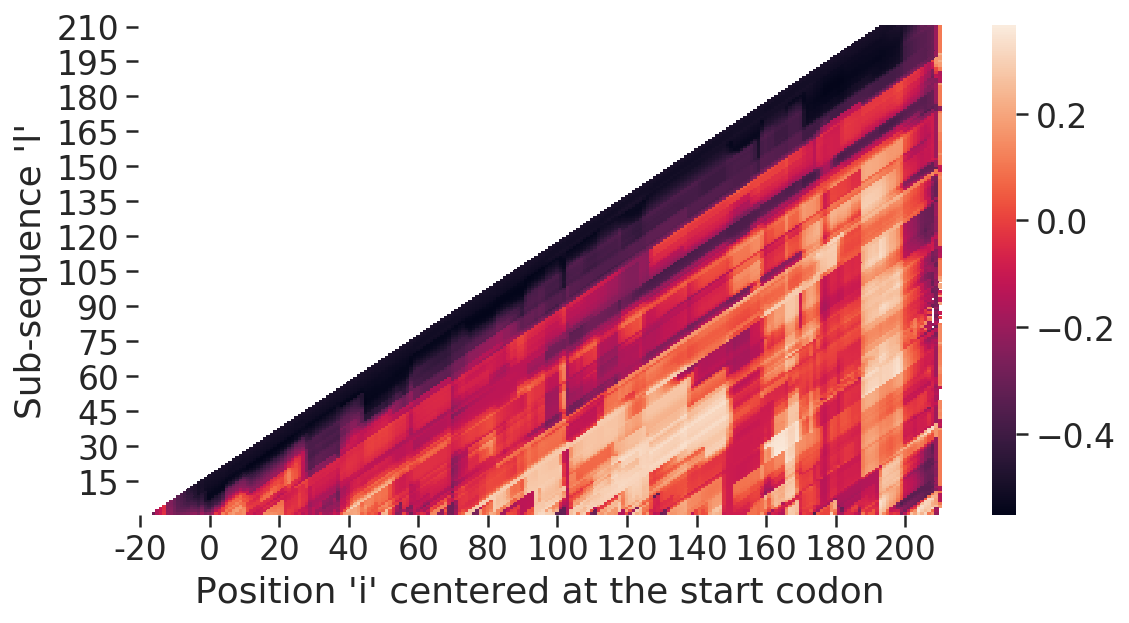

In [24]:
# Supplementary Fig 1B, left panel
plot_heatmap(20, 15, d)

In [25]:
o = get_openen(17, 300, 'data/AAAAAAAATC_openen', 96, 89, 'data/openen.dvir.pkl')
p = pd.read_csv('data/sd01.csv')
p = p[['sequence_variant','mean_protein_abundance']]
p.columns = ['id', 'Protein abundance']
p = p.set_index('id')
f = pd.read_csv('data/rnafold.dvir.out', sep='\t')
f = f.set_index('id')
d = pd.concat([o, f, p], sort=True, axis=1)
d.corr(method='spearman')

,Opening energy,Minimum free energy,Protein abundance
Opening energy,1.000000,-0.750748,-0.551764
Minimum free energy,-0.750748,1.000000,0.462251
Protein abundance,-0.551764,0.462251,1.000000


In [26]:
spearmanr(d['Opening energy'], d['Protein abundance'], nan_policy='omit')

SpearmanrResult(correlation=-0.5517641808446649, pvalue=5.790298469336669e-163)

In [27]:
# Bonferroni correction
(5.8e-163)*2041*114555

1.356079179e-154

In [28]:
spearmanr(d['Minimum free energy'], d['Protein abundance'], nan_policy='omit')

SpearmanrResult(correlation=0.4622511346573883, pvalue=1.4035214356888919e-108)

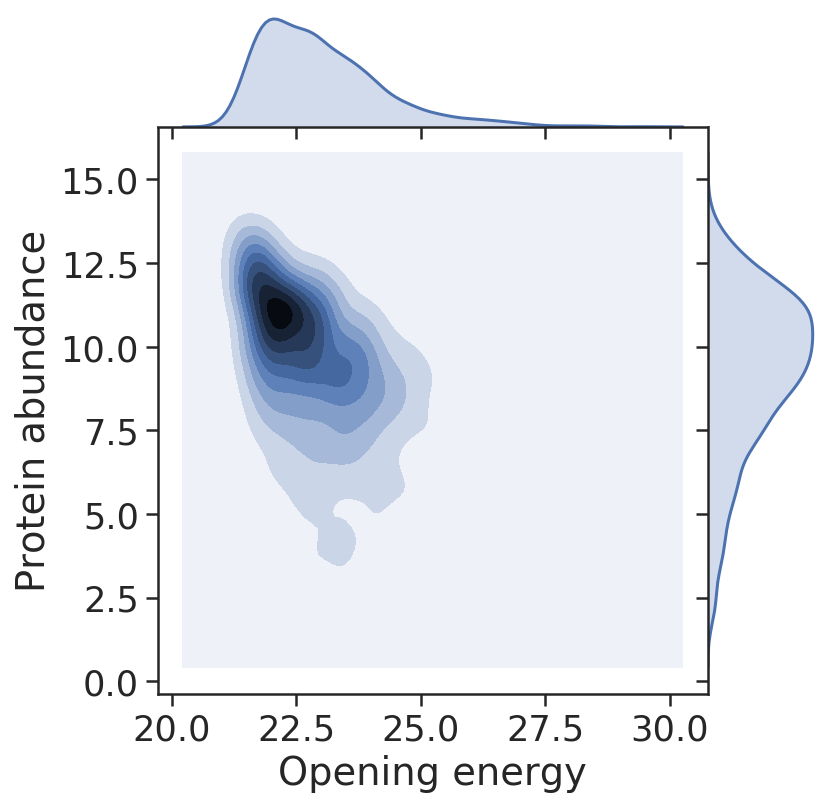

In [29]:
# Fig 1B, left panel
plot_joinplot('Opening energy', 'Protein abundance', d, 'b')

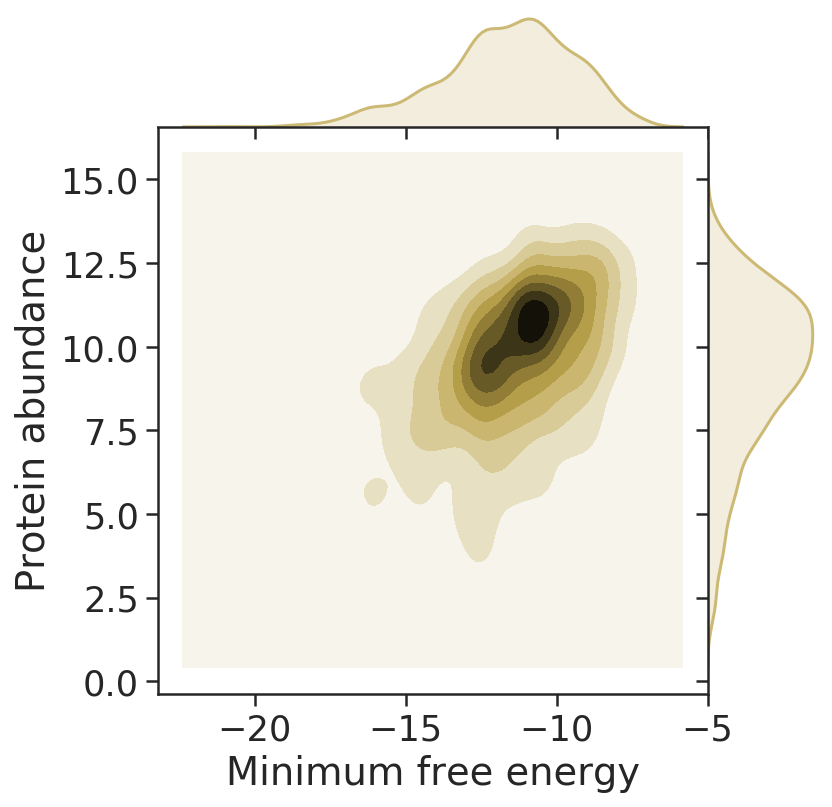

In [30]:
# Fig 1B, right panel
plot_joinplot('Minimum free energy', 'Protein abundance', d, 'y')

For *Mus musculus*, we analyzed the GFP expression dataset of Noderer et al. (2014).

```console```
# Addgene 49225
UTR5=GTGGACCATCCTCTAGACTGCCGGATCTCGAGTAACTGACTAGT
GFP=CGAATTCAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCAAGCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTTCGAATAA

# Download the supplementary data and calculate opening energy
wget http://msb.embopress.org/content/msb/10/8/748/DC6/embed/inline-supplementary-material-6.txt
awk 'NR>2 {gsub("U","T"); print $1 "\t" $2}' inline-supplementary-material-6.txt | sed '1i id\tProtein abundance' > protein.noderer.out
awk -v i=$UTR5 -v j=$GFP 'NR>1 {print ">" $1 "\n" i $1 j}' protein.noderer.out > noderer14.fa
python ../openen.py -s noderer14.fa -U 1 -x -S -n 50 -t 300 -p 16 -o openen.noderer

# Calculate the minimum free energy -30:30
awk 'NR>1 {print ">" $1 "\nCCGGATCTCGAGTAACTGACTAGT" $1 "CGAATTCAGCAAGGGCGAGGAGCTG"}' protein.noderer.out \
| RNAfold --noPS \
| awk 'BEGIN{RS=">"}NR>1{sub("\n","\t"); gsub("\n",""); print $0}' \
| awk '{gsub(/\(|\)/," "); print $1 "\t" $NF}' \
| sed '1i id\tMinimum free energy' > rnafold.noderer.out
cd ..
```

In [ ]:
d = pd.read_pickle('data/openen.dvir.pkl')
f = pd.read_csv('data/protein.noderer.out')
f.columns = ['id', 51555]
d = pd.merge(d, f, on='id')

In [ ]:
corr = pd.DataFrame(correlation(51555, d))
corr.columns = ['corr']
label = openen_label(50, 300, 'data/TTCATCATGCA_openen')
d = pd.concat([label, corr], axis=1)
d.to_pickle('data/corr.noderer.pkl')

In [33]:
d = pd.read_pickle('data/corr.noderer.pkl')
d.sort_values('corr').head()

,Position 'i' centered at the start codon,Sub-sequence 'l',corr
28456,191,2,-0.309288
28245,190,1,-0.309111
29945,198,21,-0.300660
30156,199,22,-0.299920
31323,204,139,-0.298178


In [34]:
# Add padding to x-axis
d_dummy = pd.DataFrame([-50,1,Nan], index=["Position 'i' centered at the start codon", "Sub-sequence 'l'", 'corr']).T
d = d_dummy.append(d)
d["Position 'i' centered at the start codon"] = d["Position 'i' centered at the start codon"].astype('int')
d["Sub-sequence 'l'"] = d["Sub-sequence 'l'"].astype('int')
d = d[(d["Position 'i' centered at the start codon"]>=-50) & (d["Position 'i' centered at the start codon"]<=180)]
d = d.pivot(index="Position 'i' centered at the start codon", columns="Sub-sequence 'l'", values='corr').T.sort_values("Sub-sequence 'l'", ascending=False)

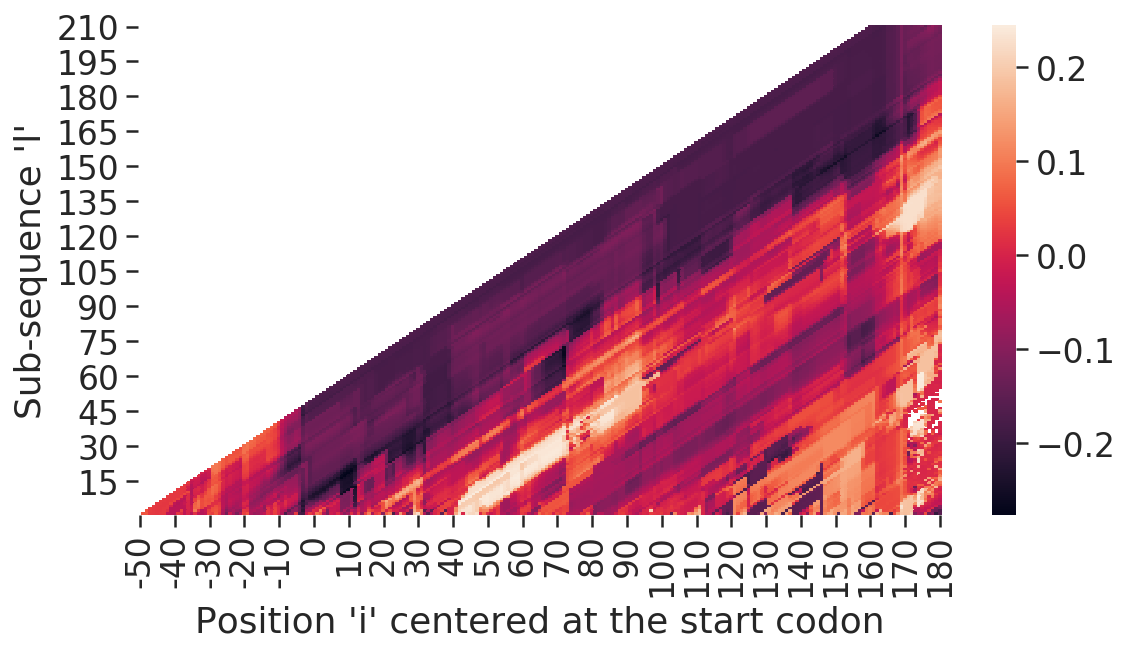

In [35]:
# Supplementary Fig 1C, left panel
plot_heatmap(10, 15, d)

In [36]:
p = pd.read_csv('data/protein.noderer.out', sep='\t')
p = p.set_index('id')
f = pd.read_csv('data/rnafold.noderer.out', sep='\t')
f = f.set_index('id')

In [40]:
# This will take a while
o = get_openen(50, 300, 'data/TTCATCATGCA_openen', 19, 11, 'data/openen.noderer.pkl')
d = pd.concat([o, f, p], sort=True, axis=1)
d.corr(method='spearman')

,Opening energy,Minimum free energy,Protein abundance
Opening energy,1.000000,-0.391379,-0.276545
Minimum free energy,-0.391379,1.000000,0.123866
Protein abundance,-0.276545,0.123866,1.000000


In [41]:
spearmanr(d['Opening energy'], d['Protein abundance'], nan_policy='omit')

SpearmanrResult(correlation=-0.27654501570205875, pvalue=0.0)

In [43]:
spearmanr(d['Minimum free energy'], d['Protein abundance'], nan_policy='omit')

SpearmanrResult(correlation=0.1238663362283729, pvalue=2.349183710462127e-222)

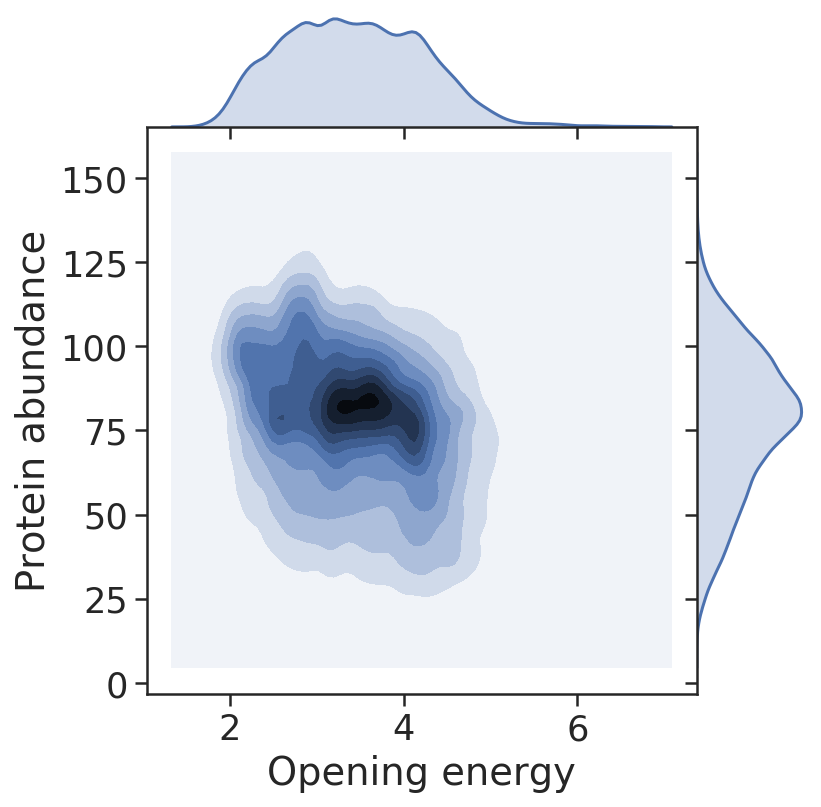

In [44]:
# Fig 1C, left panel
plot_joinplot('Opening energy', 'Protein abundance', d, 'b')

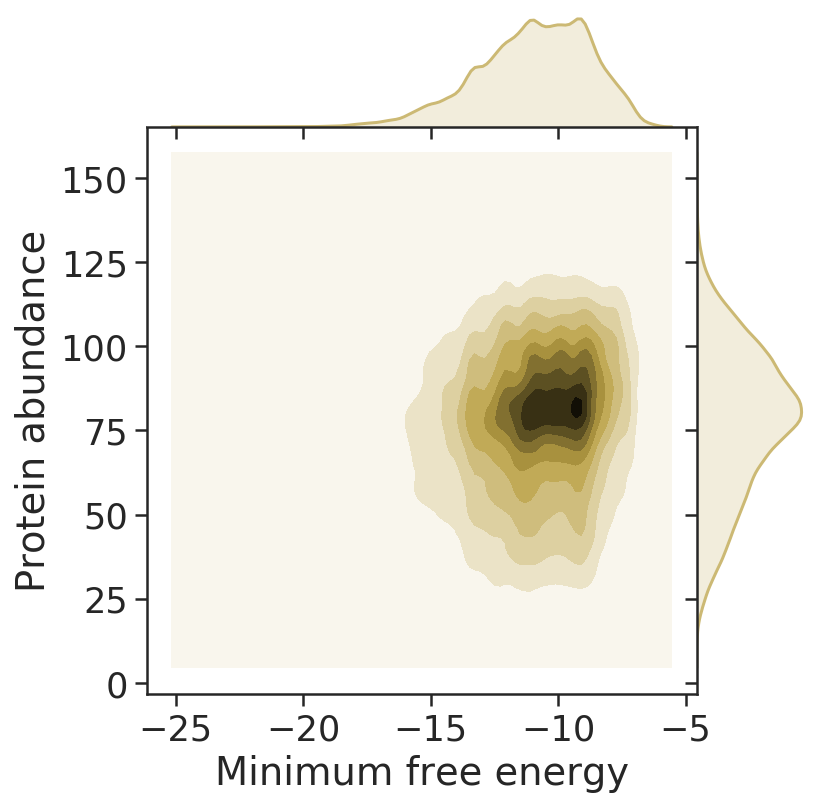

In [45]:
# Fig 1C, right panel
plot_joinplot('Minimum free energy', 'Protein abundance', d, 'y')

In [47]:
# Right panels for Supplementary Fig 1
cambray = pd.read_pickle('data/corr.cambray.pkl')
cambray.rename(columns={'corr':'cambray'}, inplace=True)
dvir = pd.read_pickle('data/corr.dvir.pkl')
dvir.rename(columns={'corr':'dvir'}, inplace=True)
noderer = pd.read_pickle('data/corr.noderer.pkl')
noderer.rename(columns={'corr':'noderer'}, inplace=True)
d = reduce(lambda left,right: pd.merge(left,right,on=["Position 'i' centered at the start codon", "Sub-sequence 'l'"]), [cambray, dvir, noderer])
d.head()

,Position 'i' centered at the start codon,Sub-sequence 'l',cambray,dvir,noderer
0,-16,1,-0.300879,-0.296744,-0.070398
1,-15,1,-0.184392,-0.153120,-0.050159
2,-15,2,-0.292095,-0.155791,-0.056454
3,-14,1,-0.040317,-0.098305,-0.030441
4,-14,2,-0.130928,-0.109242,-0.069826


In [48]:
d_dummy = pd.DataFrame({"Position 'i' centered at the start codon":[-17,-18,-19,-20], "Sub-sequence 'l'":[1,1,1,1], 'corr':[Nan,Nan,Nan,Nan]})
d = d_dummy.append(d, sort=True)

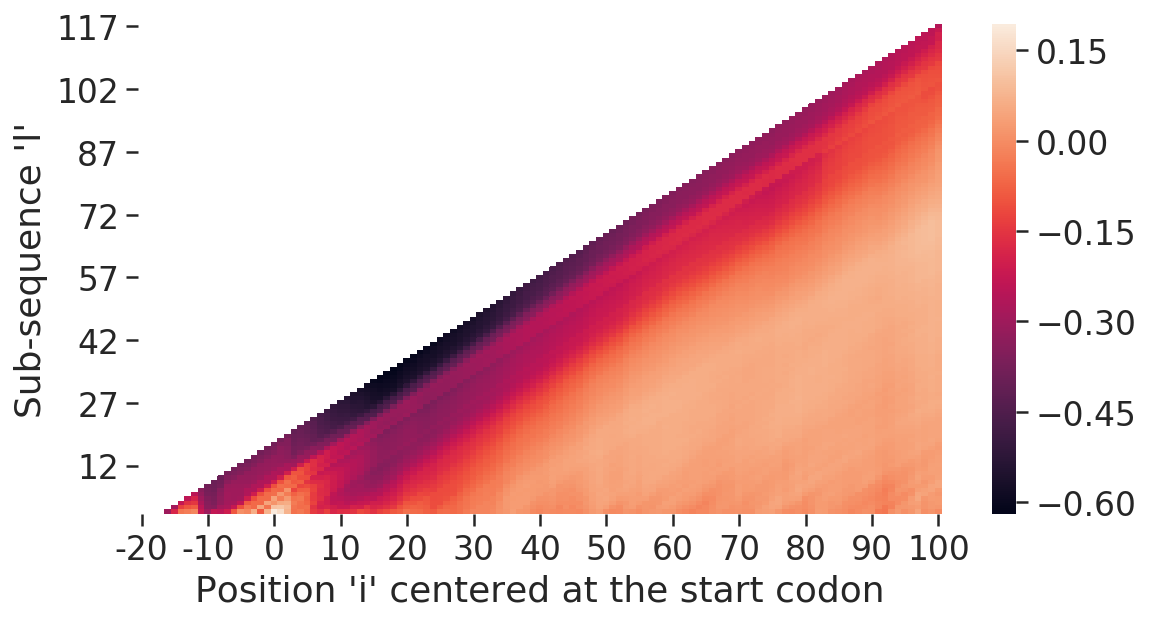

In [49]:
# Supplementary Fig 1A, right panel
cambray = d[["Position 'i' centered at the start codon", "Sub-sequence 'l'", 'cambray']]
cambray = cambray.pivot(index="Position 'i' centered at the start codon", columns="Sub-sequence 'l'", values='cambray').T.sort_values("Sub-sequence 'l'", ascending=False)
plot_heatmap(10, 15, cambray)

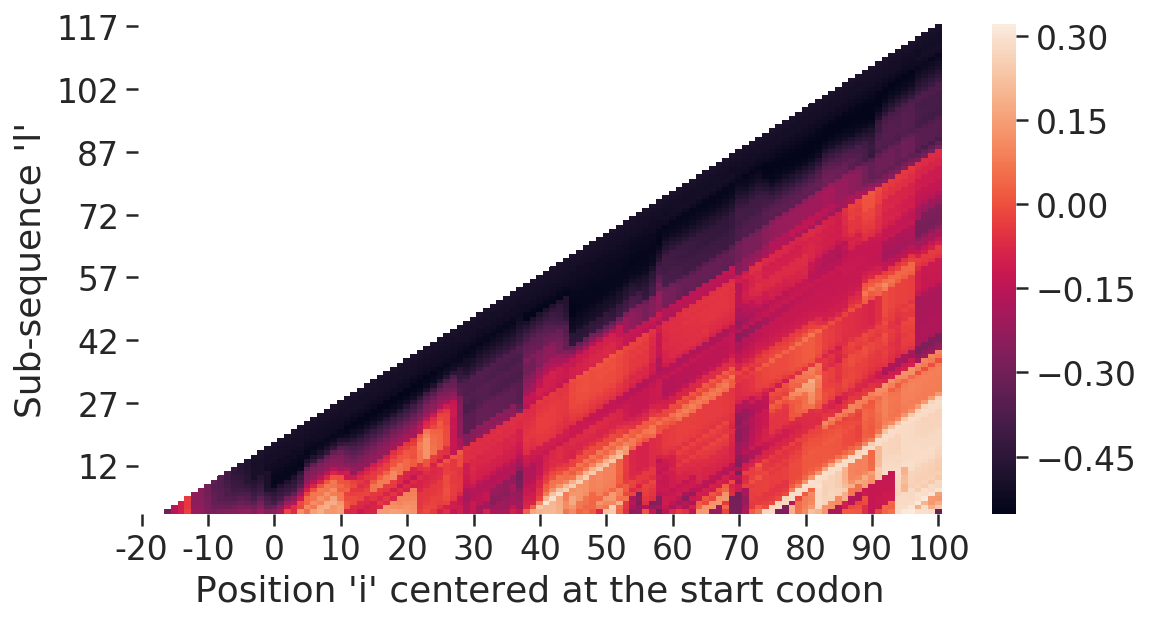

In [50]:
# Supplementary Fig 1B, right panel
dvir = d[["Position 'i' centered at the start codon", "Sub-sequence 'l'", 'dvir']]
dvir = dvir.pivot(index="Position 'i' centered at the start codon", columns="Sub-sequence 'l'", values='dvir').T.sort_values("Sub-sequence 'l'", ascending=False)
plot_heatmap(10, 15, dvir)

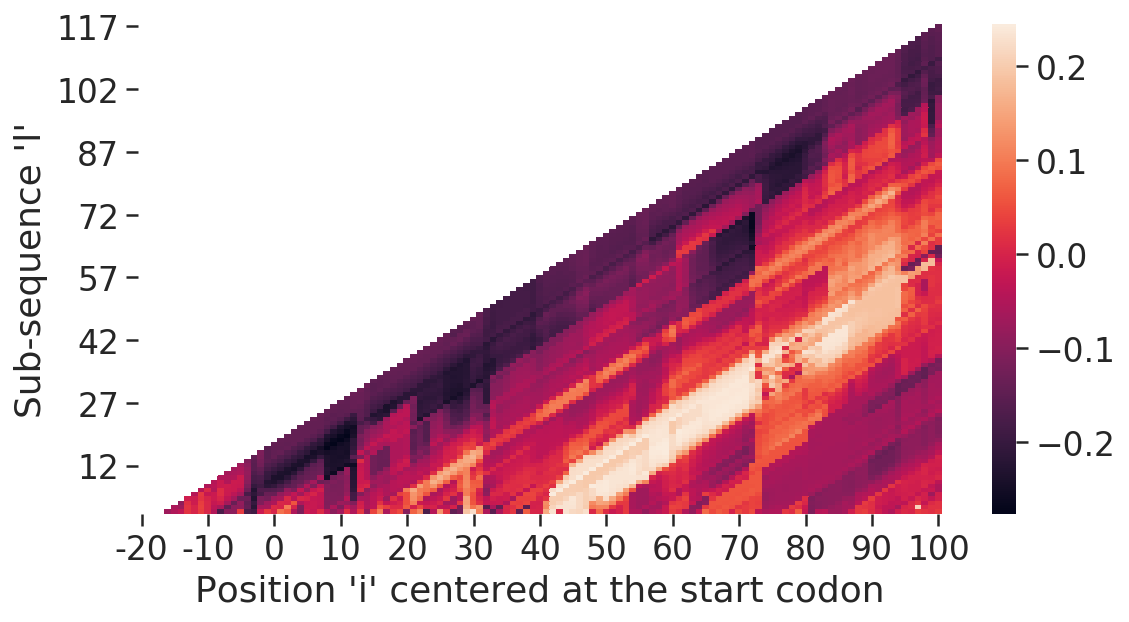

In [51]:
# Supplementary Fig 1C, right panel
noderer = d[["Position 'i' centered at the start codon", "Sub-sequence 'l'", 'noderer']]
noderer = noderer.pivot(index="Position 'i' centered at the start codon", columns="Sub-sequence 'l'", values='noderer').T.sort_values("Sub-sequence 'l'", ascending=False)
plot_heatmap(10, 15, noderer)

To predict the outcomes of recombinant protein expression, we analyze the PSI:Biology dataset (n=11,430).

```console
# Plasmid sequence
wget http://cpdwebdev.biodesign.asu.edu:8080/DNASURepository/file/sequence/pET21_NESG_sequence.doc

# Transcription start site of T7 promoter
# https://www.neb.com/faqs/2015/01/30/what-is-the-promoter-sequence-of-t7-rna-polymerase

python ../openen.py -s pET21_NESG.fa -x -S -n 71 -t 300 -p 16 -o openen.pET21_NESG
```

In [52]:
# Overview of the PSI:Biology dataset
d = pd.read_csv('data/species.txt', sep='\t', header=None)
count = pd.read_csv('data/species_count.txt', sep='\t', header=None)
count = pd.merge(count[count[2]=='0'], count[count[2]=='1'], on=1)
count.drop(['2_x','2_y'], axis=1, inplace=True)
count.columns = ['Failed', 'Genus', 'Success']
count = count.set_index('Genus')
count['Total'] = count['Failed'] + count['Success']
count['Failed (%)'] = count['Failed']*100 / (count['Failed'] + count['Success'])
count['Success (%)'] = count['Success']*100 / (count['Failed'] + count['Success'])

In [53]:
# Show genera with >=20 targets
d = count[count['Total']>=20]
d = d.loc[d.index!='Unknown']
d = d[['Failed (%)', 'Success (%)', 'Total']]

In [54]:
# Group genera with <20 with Unknown sources
o = count[count['Total']<20]
u = count.loc[count.index=='Unknown']
ou = pd.concat([u,o])
ou = pd.DataFrame({'Others':ou.sum()}).T
ou['Failed (%)'] = ou['Failed']*100 / (ou['Failed'] + ou['Success'])
ou['Success (%)'] = ou['Success']*100 / (ou['Failed'] + ou['Success'])
d = pd.concat([d,ou], sort=True).sort_values('Failed (%)')

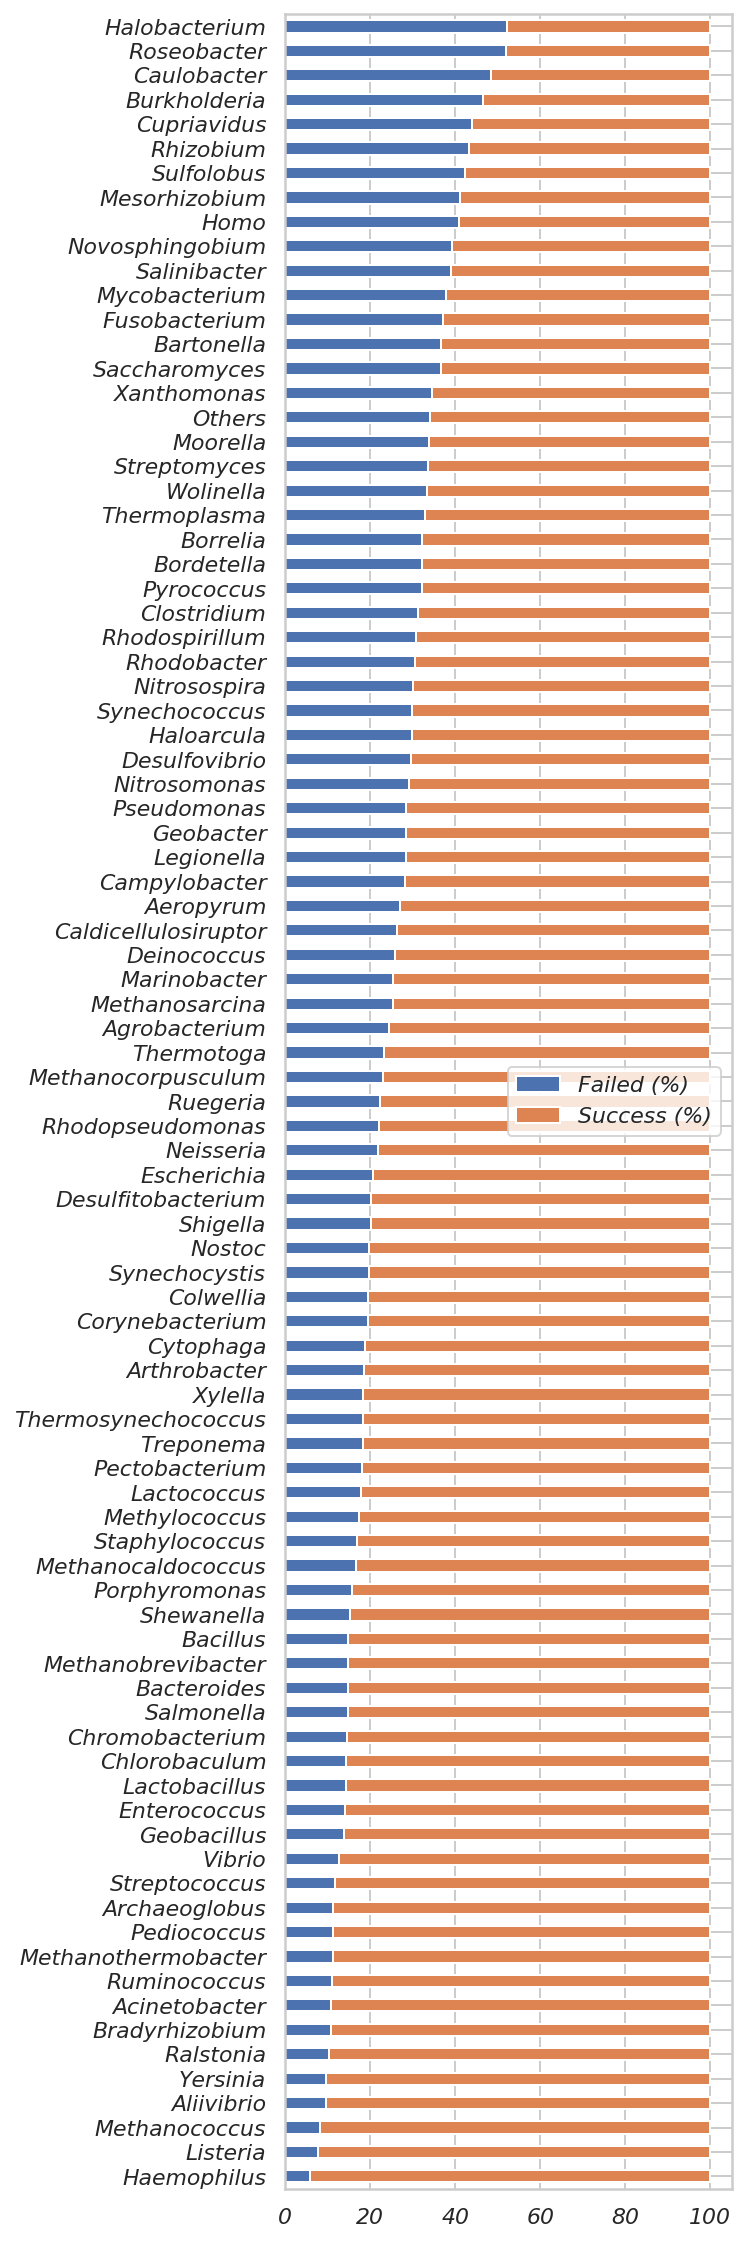

In [57]:
# Supplementary Fig S2, left panel
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(font_scale=1)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(4,20)
plt.rcParams['font.style']='italic'
d[['Failed (%)', 'Success (%)']].plot.barh(stacked=True)

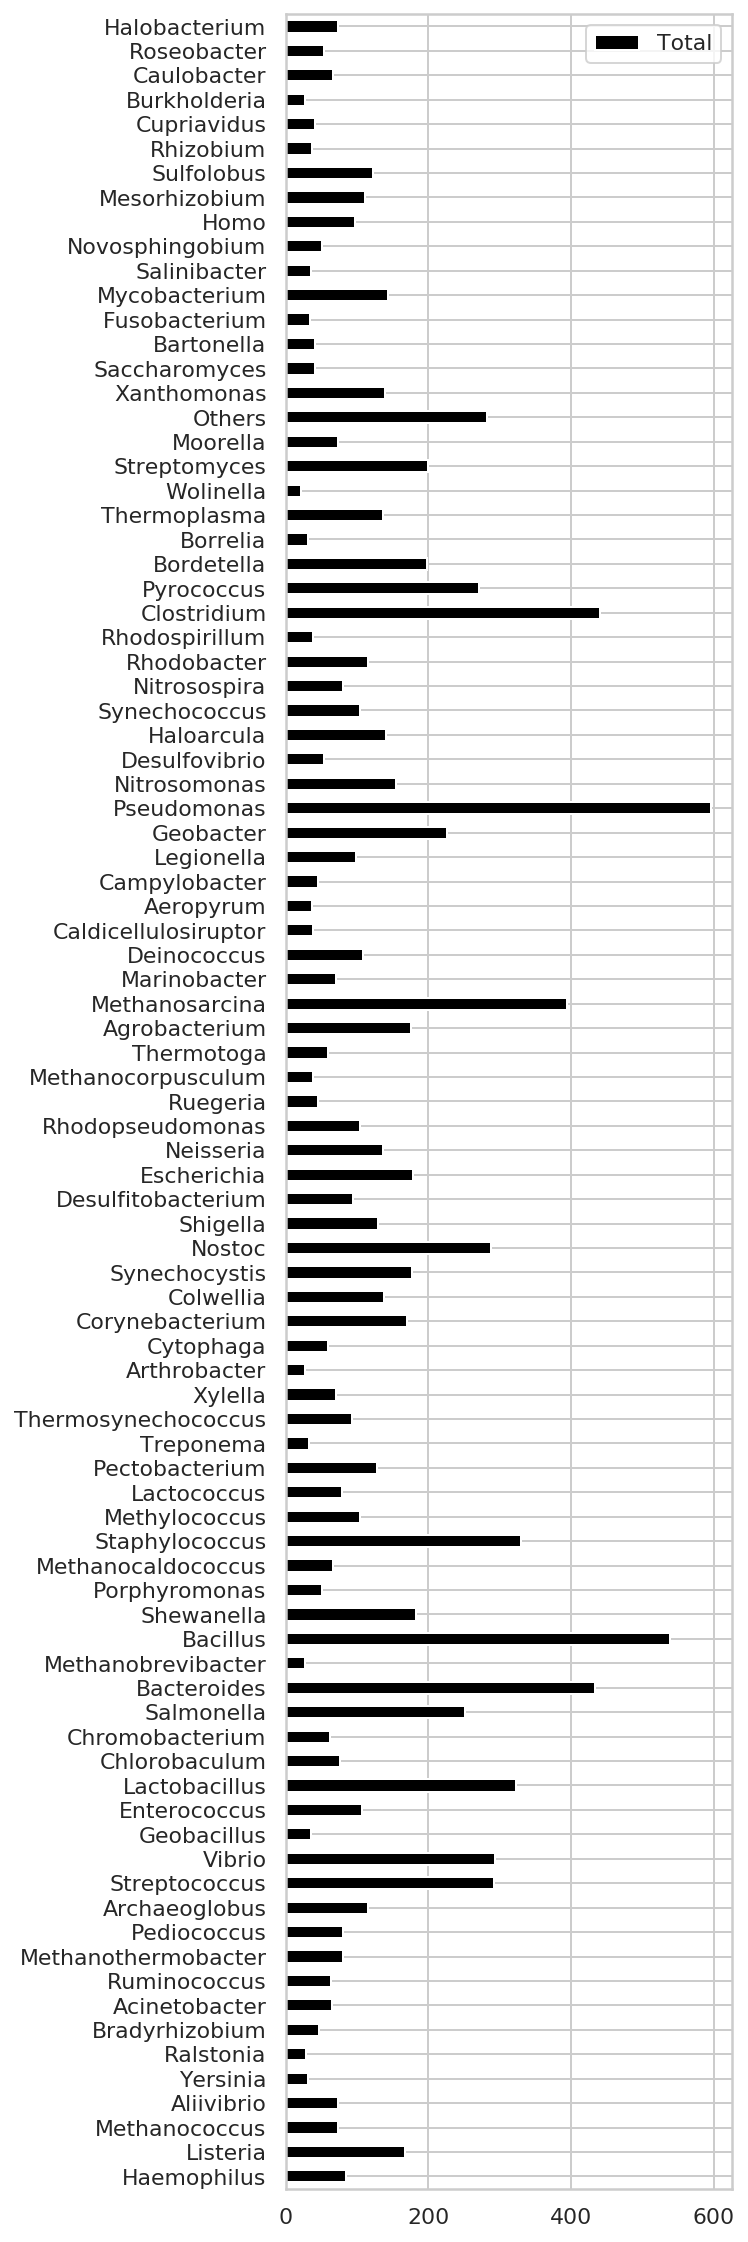

In [58]:
# Supplementary Fig S2, right panel
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(font_scale=1)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(4,20)
plt.rcParams['font.style']='normal'
d[['Total']].plot.barh(color='black')

In [59]:
# Calculate AUROC and average precision scores
# at individual sub-sequence 'l' (length 1 to 'u')
d = pd.read_pickle('data/openen.pET21_NESG.pkl')
d = d.set_index('id')
c = pd.read_csv('data/class.txt', sep='\t')
c.columns = ['id', 14706]
c = c.set_index('id').replace(2, 1)
df = pd.concat([d, c], axis=1, sort=True)
df = df.dropna()
df[14706] = df[14706].astype('int')

score = pd.DataFrame(performance(14706, df))
score = score.set_index(0)
score.columns = ['AUROC','Average Precision']

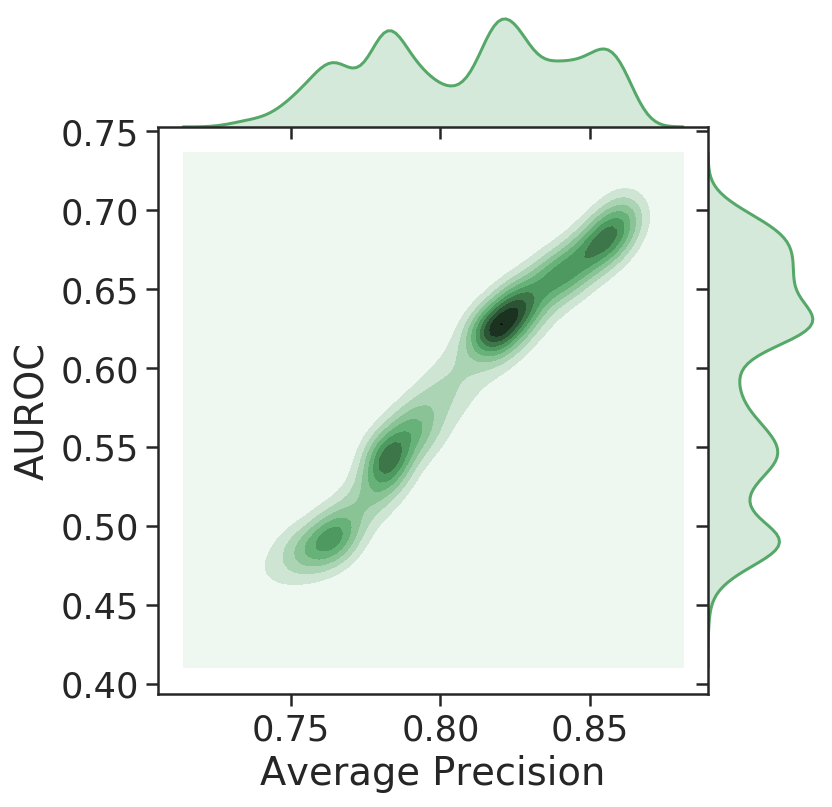

In [60]:
plot_joinplot('Average Precision', 'AUROC', score, 'g')

In [61]:
score.sort_values('Average Precision', ascending=False).head()

,AUROC,Average Precision
0,,
4696,0.702398,0.865609
4697,0.702016,0.865257
4794,0.700987,0.865059
4698,0.701768,0.864965
4316,0.703591,0.864893


In [62]:
# Get labels (row and column names) from an _openen file
# Join labels and scores
label = openen_label(71, 100, 'data/AaCD00331182_openen')
score = pd.concat([label, score], axis=1)
score.to_pickle('data/score.tt.pkl')

In [63]:
# Opening energy at i=24 and l=47 (transcript region -23 to 24 nt)
# shows the highest AUROC
score = pd.read_pickle('data/score.tt.pkl')
score.sort_values('AUROC', ascending=False).head()

,Position 'i' centered at the start codon,Sub-sequence 'l',AUROC,Average Precision
4511,24,47,0.703934,0.862696
4322,22,45,0.703916,0.863602
4504,24,40,0.703866,0.864232
4503,24,39,0.703850,0.864397
4416,23,46,0.703843,0.863499


In [64]:
# Opening energy at i=26 and l=41 (transcript region -15 to 26 nt)
# shows the highest Average Precision
score.sort_values('Average Precision', ascending=False).head()

,Position 'i' centered at the start codon,Sub-sequence 'l',AUROC,Average Precision
4696,26,41,0.702398,0.865609
4697,26,42,0.702016,0.865257
4794,27,42,0.700987,0.865059
4698,26,43,0.701768,0.864965
4316,22,39,0.703591,0.864893


In [65]:
# Drop sub-sequence l=171 to make y-axis looks nice
score.drop(score.tail(1).index, inplace=True)

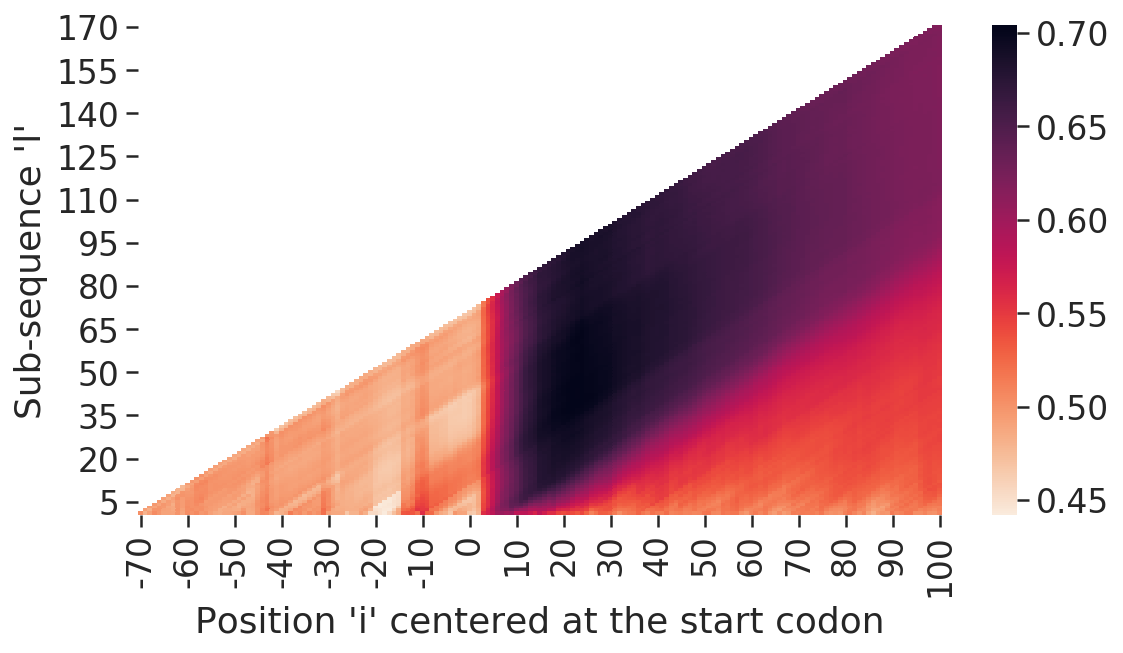

In [66]:
# Fig 2C
auroc = score.drop('Average Precision', axis=1)

# Transform correlation values to a dataframe similar to that of _openen
df = auroc.pivot(index="Position 'i' centered at the start codon", columns="Sub-sequence 'l'", values='AUROC').T.sort_values("Sub-sequence 'l'", ascending=False)
plot_heatmap(10, 15, df, colorflip=True)

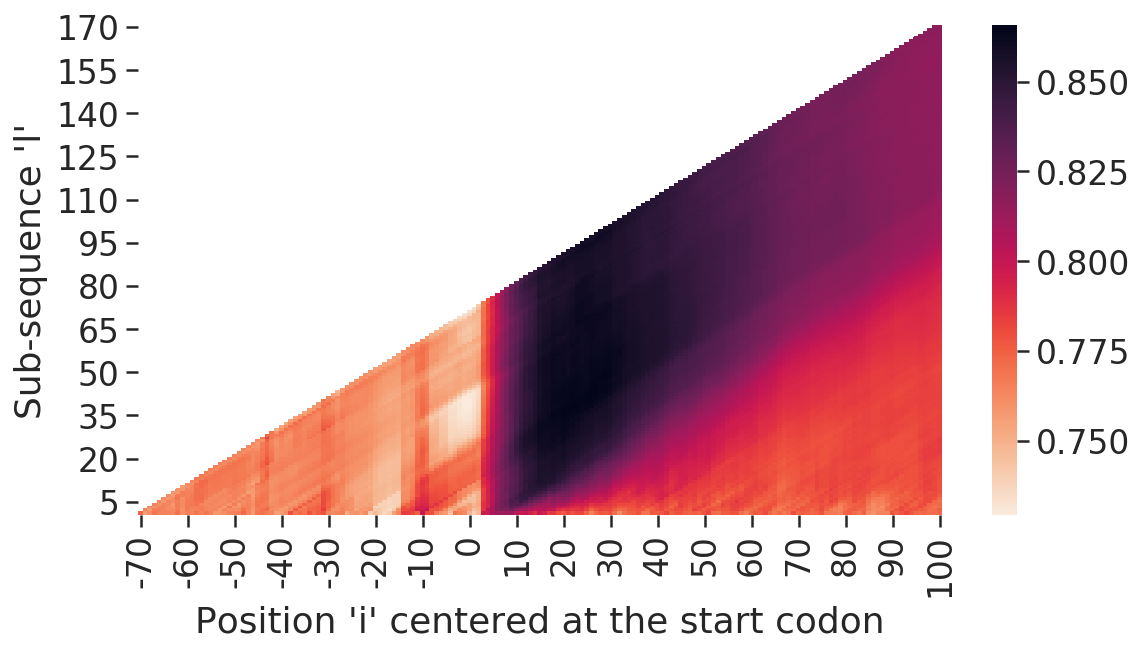

In [67]:
# As above but using average Precision
# AUROC could to be a better choice here
ap = score.drop('AUROC', axis=1)

# Transform correlation values to a dataframe similar to that of _openen
df = ap.pivot(index="Position 'i' centered at the start codon", columns="Sub-sequence 'l'", values='Average Precision').T.sort_values("Sub-sequence 'l'", ascending=False)
plot_heatmap(10, 15, df, colorflip=True)

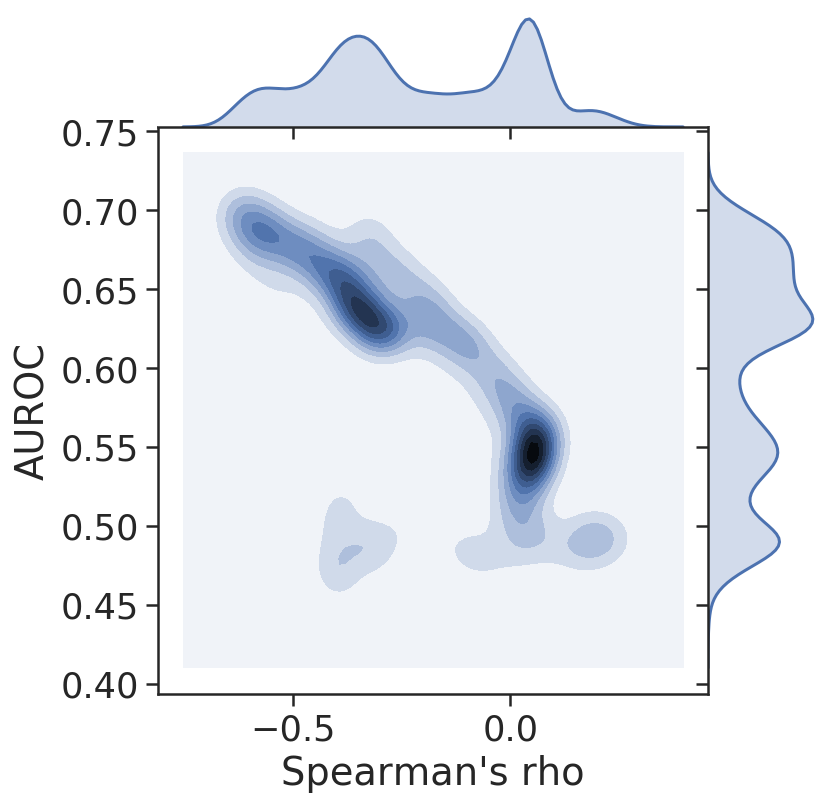

In [68]:
# Fig 2D
corr = pd.read_pickle('data/corr.cambray.pkl')
d = pd.merge(corr, auroc, on=["Position 'i' centered at the start codon","Sub-sequence 'l'"])
d.rename(columns={'corr':"Spearman's rho"}, inplace=True)
plot_joinplot("Spearman's rho", 'AUROC', d, 'b')

In [69]:
d.corr(method='spearman')["Spearman's rho"]['AUROC']

-0.7035306024528327

```console
# Download E. coli protein abundance data from paxdb
cd data
wget https://pax-db.org/data/abundances/511145-WHOLE_ORGANISM-integrated.txt

# Download E. coli genomic sequence and GTF annotation
wget ftp://ftp.ensemblgenomes.org/pub/bacteria/release-43/fasta/bacteria_0_collection/escherichia_coli_str_k_12_substr_mg1655/dna/Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.dna.toplevel.fa.gz
wget ftp://ftp.ensemblgenomes.org/pub/bacteria/release-43/gtf/bacteria_0_collection/escherichia_coli_str_k_12_substr_mg1655/Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.43.gtf.gz
gunzip Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.dna.toplevel.fa.gz

#  Get transcript sequences that contain 50 nt leader and 10 nt trailer sequences
zcat Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.42.gtf.gz \
| gtfToGenePred stdin stdout \
| awk '$6!=$7' \
| genePredToBed stdin stdout \
| awk 'BEGIN{OFS="\t"} {if($6~/+/){print $1,$2-50,$3+10,$4,$5,$6,$7,$8,$9,$10,$11,$12} 
else{print $1,$2-10,$3+50,$4,$5,$6,$7,$8,$9,$10,$11,$12}}' > ecol.50cds10.bed
bedtools getfasta \
-fi Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.dna.toplevel.fa \
-bed ecol.50cds10.bed \
-s -split -name -tab \
| sed 's/(+)//;s/(-)//' > ecol.transcripts.50cds10.txt

# Map transcript to gene ID
zcat Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.42.gtf.gz | gtfToGenePred -genePredExt stdin stdout | cut -f1,12 > tx2gene.txt
join -t$'\t' \
<(sort -k1,1 tx2gene.txt) \
<(sort -k1,1 ecol.transcripts.50cds10.txt) \
| awk '{print ">" $2 "\n" $3}' > ecol.transcripts.50cds10.fa

python ../openen.py -s ecol.transcripts.50cds10.fa -U 1 -x -S -n 50 -o openen.ecoli
```

In [70]:
# Read in pickle file for correlation analysis
d = pd.read_pickle('data/openen.ecoli.pkl')
d.head()

,id,0,1,2,3,4,5,6,7,8,...,11315,11316,11317,11318,11319,11320,11321,11322,11323,11324
0,b0001,0.0008,0.0134,0.0135,0.0080,0.0146,0.0146,0.0245,0.0251,0.0310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,b0002,0.7429,0.6628,1.1496,0.4273,0.7914,1.2751,0.3465,0.5048,0.8983,...,61.2929,61.3626,61.3657,61.4046,61.4482,61.4809,61.5245,61.5729,61.6317,62.1128
0,b0003,0.2214,1.6749,1.5920,0.9186,2.0130,1.9377,1.0545,1.4438,2.5913,...,51.8116,52.6287,52.7457,52.6820,52.6051,52.7558,53.1567,53.5555,54.6171,54.5077
0,b0004,0.0046,0.0038,0.0064,0.0035,0.0052,0.0070,0.0127,0.0146,0.0165,...,50.7024,50.6931,50.6607,50.6212,50.6645,50.6689,52.6175,53.3295,53.7199,53.8089
0,b0005,0.2229,0.0820,0.2362,0.0065,0.0836,0.2378,0.0412,0.0510,0.1147,...,47.0669,47.1918,47.2093,48.4537,49.4704,49.4765,49.4543,49.4793,49.5126,49.4323


In [71]:
# Combined proteomics dataset
f = pd.read_csv('data/511145-WHOLE_ORGANISM-integrated.txt', skiprows=11, sep='\t')
f.head()

,#internal_id,string_external_id,abundance
0,6881590,511145.b0789,1.10
1,6882118,511145.b1341,25.20
2,6882232,511145.b1475,2.97
3,6883902,511145.b3309,2603.00
4,6881517,511145.b0708,1.45


In [72]:
#Protein abundance
f['id'] = f['string_external_id'].str.replace('511145.', '')
f = f[['id','abundance']]
f.columns = ['id', 11325]

In [73]:
d = pd.merge(d, f, on='id')
d.head()

,id,0,1,2,3,4,5,6,7,8,...,11316,11317,11318,11319,11320,11321,11322,11323,11324,11325
0,b0001,0.0008,0.0134,0.0135,0.0080,0.0146,0.0146,0.0245,0.0251,0.0310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,b0002,0.7429,0.6628,1.1496,0.4273,0.7914,1.2751,0.3465,0.5048,0.8983,...,61.3626,61.3657,61.4046,61.4482,61.4809,61.5245,61.5729,61.6317,62.1128,317.0
2,b0003,0.2214,1.6749,1.5920,0.9186,2.0130,1.9377,1.0545,1.4438,2.5913,...,52.6287,52.7457,52.6820,52.6051,52.7558,53.1567,53.5555,54.6171,54.5077,76.3
3,b0004,0.0046,0.0038,0.0064,0.0035,0.0052,0.0070,0.0127,0.0146,0.0165,...,50.6931,50.6607,50.6212,50.6645,50.6689,52.6175,53.3295,53.7199,53.8089,530.0
4,b0005,0.2229,0.0820,0.2362,0.0065,0.0836,0.2378,0.0412,0.0510,0.1147,...,47.1918,47.2093,48.4537,49.4704,49.4765,49.4543,49.4793,49.5126,49.4323,0.0


In [74]:
d.shape

(4092, 11327)

In [75]:
# Remove zero protein level
d = d[d[11325] > 0]
d.shape

(3725, 11327)

In [76]:
# Calculate correlation at individual sub-sequence 'l' (length 1 to 'u')
corr = pd.DataFrame(correlation(11325, d))
corr.columns = ['corr']
# Get labels (row and column names) from an _openen file
# Join labels and correlation values
label = openen_label(50, 100, 'data/b0004_openen')
d = pd.concat([label, corr], axis=1)
d.to_pickle('data/corr.ecoli.pkl')

In [77]:
# Opening energy at i=16 and l=41 (transcript region -25 to 16 nt)
# has the strongest correlation with protein level
d = pd.read_pickle('data/corr.ecoli.pkl')
d.sort_values('corr').head()

,Position 'i' centered at the start codon,Sub-sequence 'l',corr
2185,16,41,-0.174599
2119,15,40,-0.174281
2186,16,42,-0.173935
2253,17,43,-0.173933
2118,15,39,-0.173852


In [78]:
# Add padding to x-axis
d_dummy = pd.DataFrame([-50,1,Nan], index=["Position 'i' centered at the start codon", "Sub-sequence 'l'", 'corr']).T
d = d_dummy.append(d)
d["Position 'i' centered at the start codon"] = d["Position 'i' centered at the start codon"].astype('int')
d["Sub-sequence 'l'"] = d["Sub-sequence 'l'"].astype('int')
# Transform correlation values to a dataframe similar to that of _openen
d = d.pivot(index="Position 'i' centered at the start codon", columns="Sub-sequence 'l'", values='corr').T.sort_values("Sub-sequence 'l'", ascending=False)

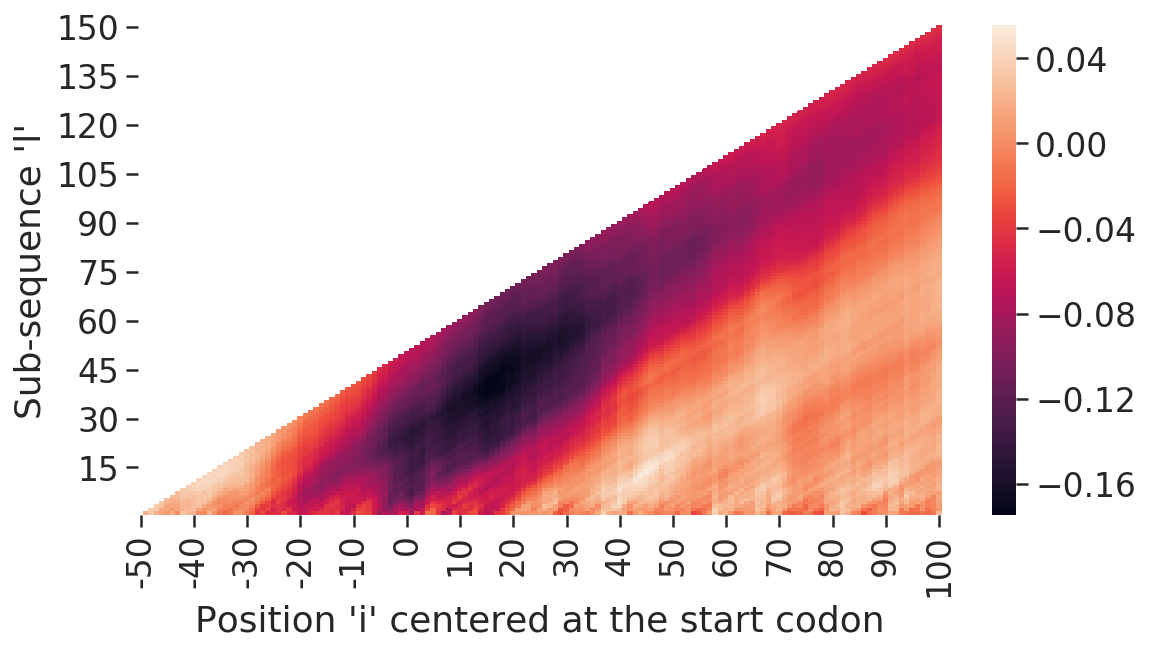

In [79]:
# Fig 2E
plot_heatmap(10, 15, d)

In [80]:
# Get opening energy -24:24
o = get_openen(50, 100, 'data/b0004_openen', 48, 24, 'data/openen.ecoli.pkl')

In [81]:
o = o.reset_index()
o.columns = ['id', 'Opening energy']

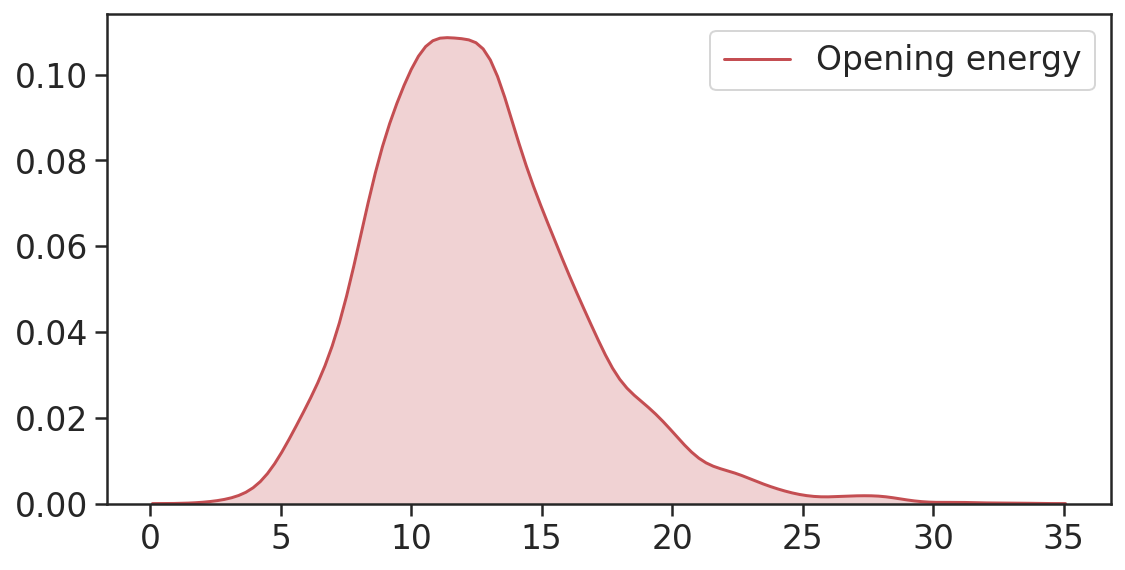

In [82]:
sns.kdeplot(o['Opening energy'], shade=True, color="r")

In [83]:
# Calculate correlation
f = pd.read_csv('data/511145-WHOLE_ORGANISM-integrated.txt', skiprows=11, sep='\t')
f['id'] = f['string_external_id'].str.replace('511145.', '')
f = f[['id','abundance']]
d = pd.merge(o, f, on='id')

In [84]:
d.corr(method='spearman')["Opening energy"]['abundance']

-0.1604310358856616